# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score , ConfusionMatrixDisplay
from skimage import color, feature, exposure
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

In [4]:
data = pd.read_csv(r"C:\Users\Admin\Downloads\icml_face_data.csv")
data.head(5)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
def parse_data(data: pd.DataFrame):
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    print("Image array shape:", image_array.shape)
    print("Image array dtype:", image_array.dtype)
    print("Image array min/max values:", image_array.min(), image_array.max())

    return image_array, image_label
image_array, image_label = parse_data(data)

Image array shape: (35887, 48, 48)
Image array dtype: float64
Image array min/max values: 0.0 255.0


In [8]:
duplicates_to_delete = data[data.duplicated(["pixels"], keep=False)]
data_cleaned = pd.concat([data, duplicates_to_delete]).drop_duplicates(keep=False)
data_cleaned = data_cleaned.reset_index()
data = data_cleaned

In [10]:
def remap(column, mapping_rule):
    remapped = column.map(mapping_rule)
    return remapped

In [12]:
def to_square_image(images, size):
    image_list = []
    for i in range(len(images)):
        converted = np.array(images[i].split(" "), dtype=np.uint8)
        image_list.append(converted.reshape(size, size))
    return image_list

In [14]:
pixels = data["pixels"]
images = to_square_image(pixels, 48)
data["images"] = images

In [16]:
column = data["emotion"]
mapping = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral",
}
remapped = remap(column, mapping)
data["emotion_label"] = remapped

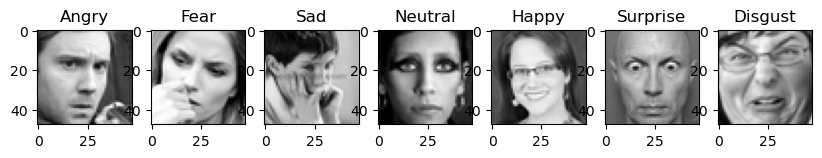

In [18]:
emotion_list = list(data["emotion_label"].unique())
fig, axs = plt.subplots(
    1, len(emotion_list), figsize=(10, 5), facecolor="w", edgecolor="k"
)
fig.subplots_adjust(hspace=1, wspace=0.2)
axs = axs.ravel()
for i in range(len(emotion_list)):
    axs[i].imshow(
        data[data["emotion_label"] == emotion_list[i]].iloc[0]["images"], cmap="gray"
    )
    axs[i].set_title(
        data[data["emotion_label"] == emotion_list[i]].iloc[0]["emotion_label"]
    )

In [20]:
def select_sample_images(images, labels, num_samples=5):
    sample_images = []
    class_names = np.unique(labels)
    for class_name in class_names:
        class_indices = np.where(labels == class_name)[0][:num_samples]
        sample_images.extend(images[class_indices])
    return sample_images, class_names

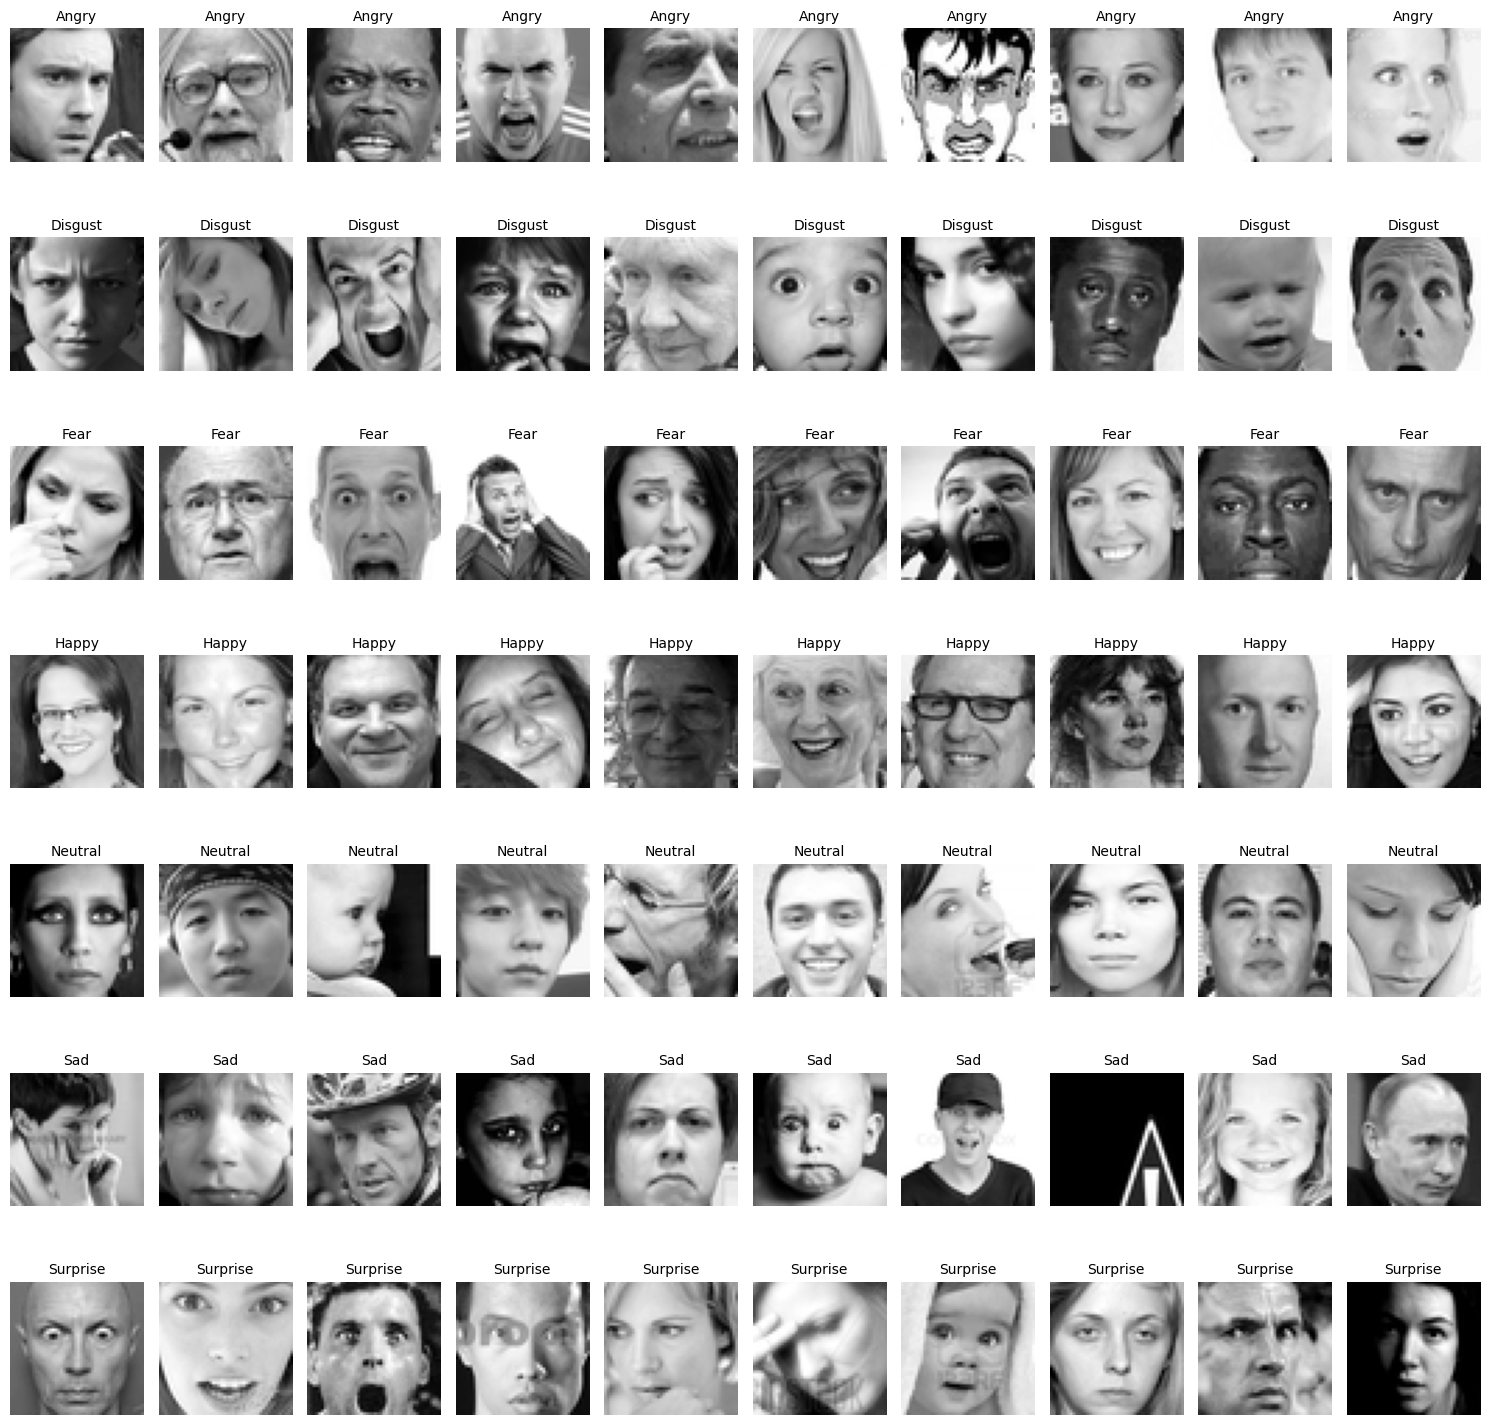

In [22]:
num_samples = 10
sample_images, class_names = select_sample_images(image_array, data["emotion_label"], num_samples)

num_classes = len(class_names)
fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 15))
for i, class_name in enumerate(class_names):
    class_indices = np.where(data["emotion_label"] == class_name)[0][:num_samples]
    for j, idx in enumerate(class_indices):
        axes[i, j].imshow(image_array[idx], cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(class_name, fontsize=10)

plt.tight_layout()
plt.show()

* Define a remap function that takes in column and mapping dictionary, then returns  a new column with the remapped values. Applies this function to the emotion column in the data, using the provided mapping

The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

# Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [28]:
from sklearn.decomposition import PCA

In [30]:
image_array_flat = image_array.reshape(-1, 48*48)

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
image_array_scaled = scaler.fit_transform(image_array_flat)

In [34]:
pca = PCA(n_components=2)
image_array_pca = pca.fit_transform(image_array_scaled)

In [36]:
remapped.shape

(32518,)

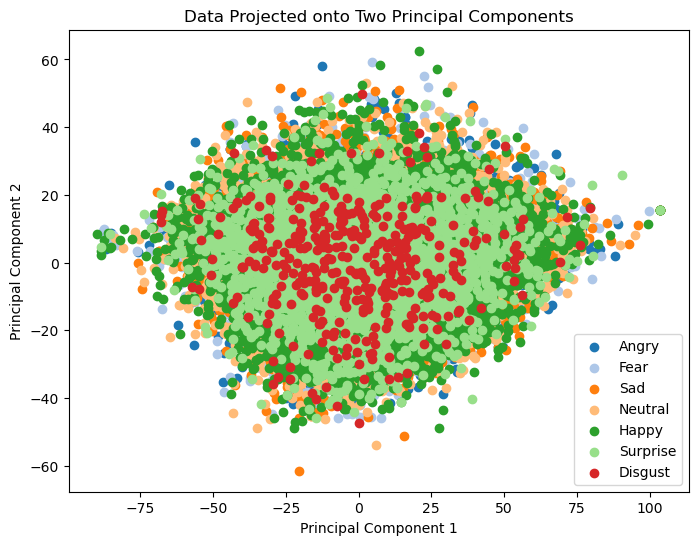

In [38]:
import matplotlib.pyplot as plt

emotion_labels = data["emotion_label"].unique()

cmap = plt.cm.tab20
colors = [cmap(i) for i in range(len(emotion_labels))]

plt.figure(figsize=(8, 6))
for i, label in enumerate(emotion_labels):
    mask = data["emotion_label"] == label
    plt.scatter(image_array_pca[:32518, 0][mask], image_array_pca[:32518, 1][mask], label=label, color=colors[i])

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Data Projected onto Two Principal Components")
plt.legend()
plt.show()

In [40]:
print(f"Number of components retained: {pca.n_components_}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.2f}")

Number of components retained: 2
Explained variance ratio: 0.38


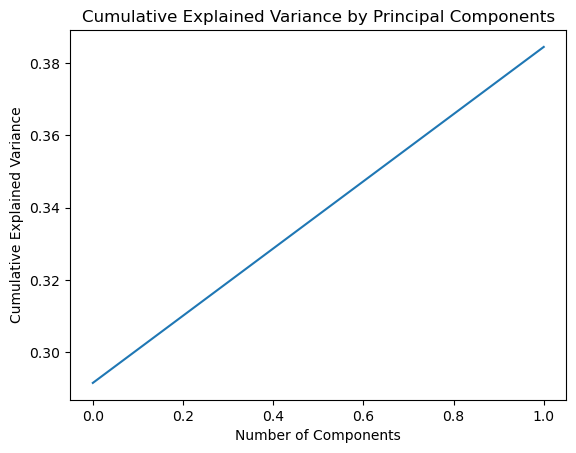

In [42]:
import matplotlib.pyplot as plt

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.show()

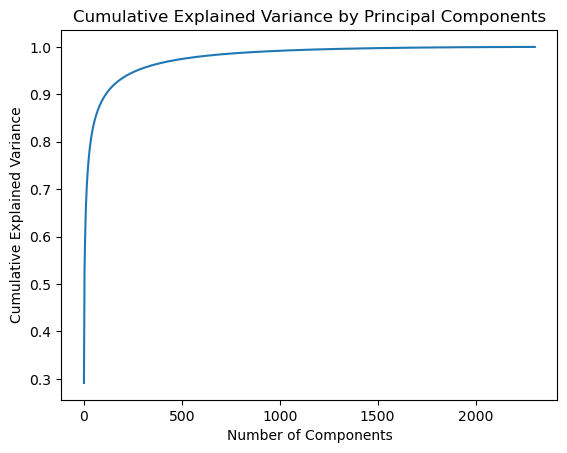

Optimal number of components: 270


In [44]:
pca = PCA().fit(image_array_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.show()

threshold = 0.95
n_components = np.argmax(cumulative_variance >= threshold) + 1
print(f'Optimal number of components: {n_components}')

In [31]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


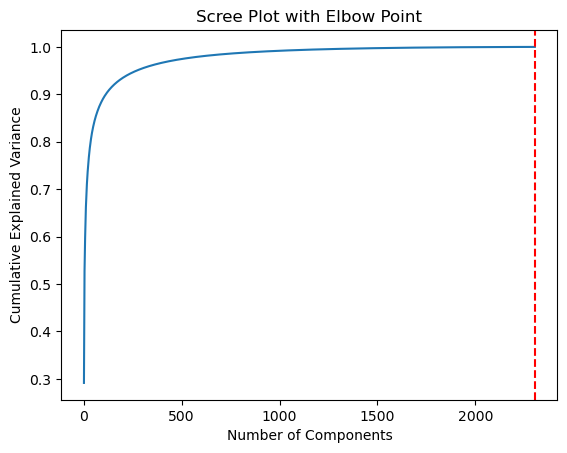

In [46]:
import matplotlib.pyplot as plt
from kneed import KneeLocator

cum_var = np.cumsum(pca.explained_variance_ratio_)

kl = KneeLocator(range(1, len(cum_var) + 1), cum_var, curve='convex', direction='increasing')
elbow_point = kl.elbow

plt.plot(range(1, len(cum_var) + 1), cum_var)
plt.axvline(x=elbow_point, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot with Elbow Point')
plt.show()

In [48]:
threshold = 0.85
n_components = np.argmax(cumulative_variance  >= threshold) + 1
print(f'Optimal number of components: {n_components}')

Optimal number of components: 59


In [50]:
threshold = 0.9
n_components = np.argmax(cumulative_variance  >= threshold) + 1
print(f'Optimal number of components: {n_components}')

Optimal number of components: 113


In [52]:
threshold = 0.95
n_components = np.argmax(cumulative_variance  >= threshold) + 1
print(f'Optimal number of components: {n_components}')

Optimal number of components: 270


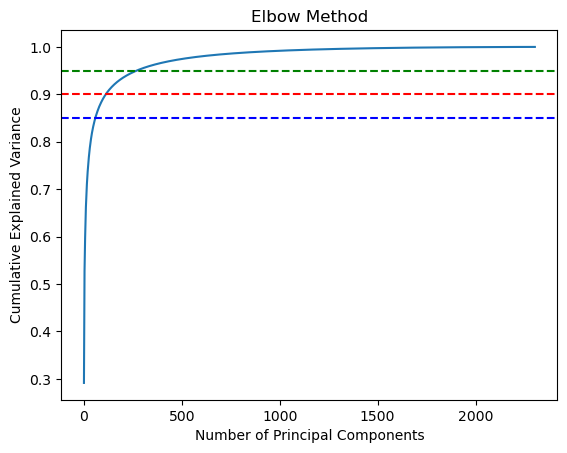

In [54]:
fig, ax = plt.subplots()

ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('Elbow Method')

ax.axhline(y=0.9, color='r', linestyle='--', label='0.9 Threshold')
ax.axhline(y=0.95, color='g', linestyle='--', label='0.95 Threshold')
ax.axhline(y=0.85, color='b' ,linestyle='--',label= '0.85 Thresold')

plt.show()

In [56]:
threshold = 0.925
n_components = np.argmax(cumulative_variance  >= threshold) + 1
print(f'Optimal number of components: {n_components}')

Optimal number of components: 168


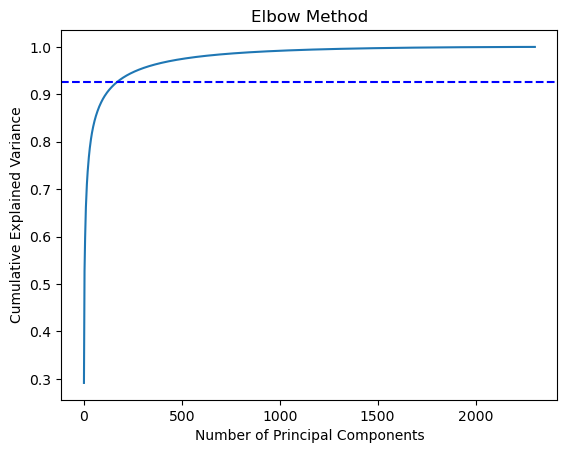

In [58]:
fig, ax = plt.subplots()

ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('Elbow Method')

ax.axhline(y=0.925, color='b' ,linestyle='--',label= '0.925 Thresold')


# Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

* By using pca.explained_variance, we can follow these step to gain the result: 
    * Step1: Calculate the cumulative explained variance
    * Step2: Visualize/ Plot the cummulative explained variance and analyze based on this
    * Step3: Identify the "elbow point"
    * Final: Select the optimal number of components based on the plot, choose the option that can balance most for our model, avoid overfitting but not lose important features.


## Determine the optimal number of PCs here
* Based on the result above, the optimal number of PCs to this dataset that i choose is 130 to keep about 90% of variance 

## Explain the selection 
* From the plot, we compare three option with three thresold(0.85, 0,9, 0,95) 
  * We can see, that the cumulative explained variance curve starts to flatten out around 1500-1600 components, which corresponds to a cumulative explained variance of around 0.925
  * 0.85 Thresold(59PCs): Avoid overfitting, faster model but may lose  some important emotional features, potentially affecting model performance.
  * 0.9 Thresold(131PCs): Keep more feature than fist option, model may more balance, may lead to overfitting 
  * 0.95 Thresold(270PCs): Better model but may increase in training time and overfitting
  * The elbow point is around 0.925 but it lead to too much component(170), so based on those reasons, set thresold at 0.9 to keep 90% of variance with 130 components could be the best choice for this dataset, our model will balance and avoid losing too much feature from dataset. 

In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
image_array_scaled = scaler.fit_transform(image_array_flat)

In [66]:
from sklearn.decomposition import PCA

pca = PCA(n_components=130)
image_array_pca = pca.fit_transform(image_array_scaled)

In [68]:
image_array_pca.shape, data['emotion_label'].shape

((35887, 130), (32518,))

In [70]:
subset = image_array_pca[:32518]
subset.shape 

(32518, 130)

In [72]:
subset.shape, data['emotion_label'].shape

((32518, 130), (32518,))

## 3. Image Classification

## Original Data

In [76]:
org_df=pd.read_csv(r"C:\Users\Admin\Downloads\icml_face_data.csv")
org_df.head(5)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [78]:
org_df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [80]:
org_df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [82]:
def parse_data(org_df):
    image_array = np.zeros(shape=(len(org_df), 48, 48, 1))
    image_label = np.array(list(map(int, org_df['emotion'])))
    
    for i, row in enumerate(org_df.index):
        image = np.fromstring(org_df.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48, 1))
        image_array[i] = image
        
    return image_array, image_label

# MLP with original data

In [85]:
from sklearn.model_selection import train_test_split

train_df, val_test_df = train_test_split(org_df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

train_imgs, train_lbls = parse_data(train_df)
val_imgs, val_lbls = parse_data(val_df)
test_imgs, test_lbls = parse_data(test_df)

In [86]:
X_train, y_train = train_imgs, train_lbls
X_test, y_test = test_imgs, test_lbls

In [89]:
len(X_train), len(X_test)

(21532, 7178)

In [91]:
X_train_reshaped = X_train.reshape(-1, 48*48*1)
X_test_reshaped = X_test.reshape(-1, 48*48*1)

scaler = StandardScaler()
X_normalized_train = scaler.fit_transform(X_train_reshaped)
X_normalized_test = scaler.transform(X_test_reshaped)

In [90]:
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

pipe_line = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000))
pipe_line.fit(X_normalized_train, y_train)
print(classification_report(y_test, pipe_line.predict(X_normalized_test)))

              precision    recall  f1-score   support

           0       0.28      0.26      0.27       940
           1       0.30      0.31      0.30       111
           2       0.33      0.33      0.33      1045
           3       0.54      0.55      0.54      1814
           4       0.30      0.30      0.30      1182
           5       0.54      0.53      0.53       836
           6       0.35      0.36      0.36      1250

    accuracy                           0.40      7178
   macro avg       0.38      0.38      0.38      7178
weighted avg       0.40      0.40      0.40      7178



# KFold with MLP using Keras

In [68]:
from sklearn.model_selection import KFold

n_splits = 3

loss_per_fold = []
acc_per_fold = []
loss_test_fold = []
accuracy_test_fold = []

kfold = KFold(n_splits=n_splits, shuffle=True)

In [70]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import models, layers

history_list = []
for fold, (train_indices, val_indices) in enumerate(kfold.split(train_imgs, train_lbls)):

    print(f'Fold {fold+1}/{n_splits}:')

    x_train, y_train = train_imgs[train_indices], train_lbls[train_indices]
    x_val, y_val = train_imgs[val_indices], train_lbls[val_indices]

    model_mlp = keras.Sequential([
        layers.Flatten(input_shape=(48, 48, 1)),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=7, activation='softmax')
    ])
    model_mlp.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                      optimizer=keras.optimizers.Adam(lr=1e-3),
                      metrics=['accuracy'])

    history = model_mlp.fit(x_train, y_train, epochs=5, batch_size=32,
                            validation_data=(x_val, y_val), verbose=1)
    history_list.append(history)

    loss, accuracy = model_mlp.evaluate(x_val, y_val, verbose=0)
    print(f'Validation accuracy: {accuracy*100:.2f}%')
    loss_per_fold.append(loss)
    acc_per_fold.append(accuracy*100)

    loss_test, accuracy_test = model_mlp.evaluate(test_imgs, test_lbls, verbose=0)
    print(f'Test accuracy: {accuracy_test*100:.2f}%')
    loss_test_fold.append(loss_test)
    accuracy_test_fold.append(accuracy_test*100)

Fold 1/3:


Epoch 1/5
449/449 [==============================] - 7s 11ms/step - loss: 33.4971 - accuracy: 0.2056 - val_loss: 12.8998 - val_accuracy: 0.1939
Epoch 2/5
449/449 [==============================] - 4s 9ms/step - loss: 9.1876 - accuracy: 0.2376 - val_loss: 7.7579 - val_accuracy: 0.2669
Epoch 3/5
449/449 [==============================] - 4s 9ms/step - loss: 4.4788 - accuracy: 0.2422 - val_loss: 2.4134 - val_accuracy: 0.2581
Epoch 4/5
449/449 [==============================] - 4s 8ms/step - loss: 2.5258 - accuracy: 0.2592 - val_loss: 2.3800 - val_accuracy: 0.2821
Epoch 5/5
449/449 [==============================] - 3s 8ms/step - loss: 1.9391 - accuracy: 0.2810 - val_loss: 1.8651 - val_accuracy: 0.2867
Validation accuracy: 28.67%
Test accuracy: 28.03%
Fold 2/3:


Epoch 1/5
449/449 [==============================] - 5s 9ms/step - loss: 25.3621 - accuracy: 0.2038 - val_loss: 5.9114 - val_accuracy: 0.2040
Epoch 2/5
449/449 [==============================] - 5s 10ms/step - loss: 3.2288 - accuracy: 0.2130 - val_loss: 4.4422 - val_accuracy: 0.2543
Epoch 3/5
449/449 [==============================] - 4s 8ms/step - loss: 2.2657 - accuracy: 0.2382 - val_loss: 2.2442 - val_accuracy: 0.2353
Epoch 4/5
449/449 [==============================] - 4s 8ms/step - loss: 2.0024 - accuracy: 0.2583 - val_loss: 2.1038 - val_accuracy: 0.2260
Epoch 5/5
449/449 [==============================] - 4s 9ms/step - loss: 1.9194 - accuracy: 0.2638 - val_loss: 1.9070 - val_accuracy: 0.2330
Validation accuracy: 23.30%
Test accuracy: 23.74%
Fold 3/3:


Epoch 1/5
449/449 [==============================] - 6s 10ms/step - loss: 27.5816 - accuracy: 0.2081 - val_loss: 6.7710 - val_accuracy: 0.2511
Epoch 2/5
449/449 [==============================] - 4s 9ms/step - loss: 5.8530 - accuracy: 0.2350 - val_loss: 2.7328 - val_accuracy: 0.2077
Epoch 3/5
449/449 [==============================] - 6s 13ms/step - loss: 2.3378 - accuracy: 0.2591 - val_loss: 2.0089 - val_accuracy: 0.2355
Epoch 4/5
449/449 [==============================] - 6s 13ms/step - loss: 2.0113 - accuracy: 0.2683 - val_loss: 2.0557 - val_accuracy: 0.2458
Epoch 5/5
449/449 [==============================] - 4s 10ms/step - loss: 1.8900 - accuracy: 0.2829 - val_loss: 1.8870 - val_accuracy: 0.2631
Validation accuracy: 26.31%
Test accuracy: 26.11%


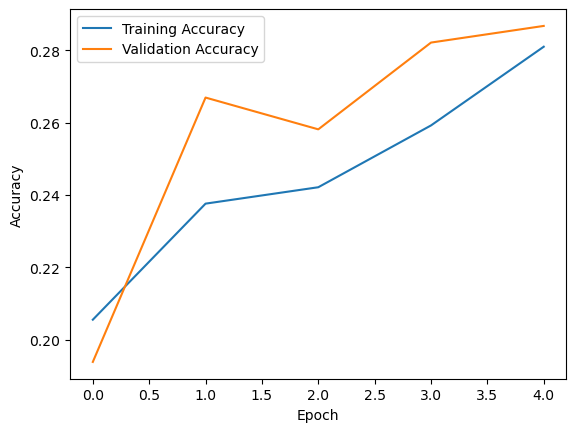

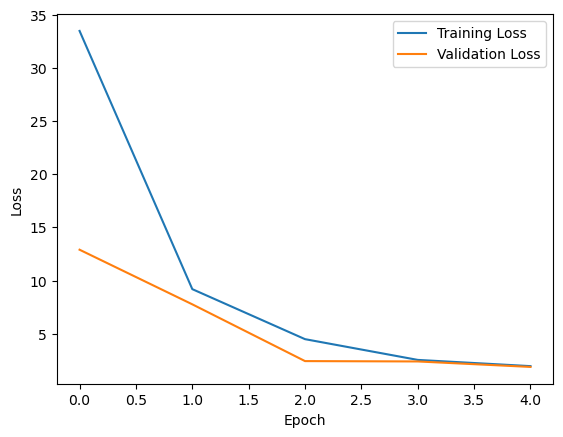

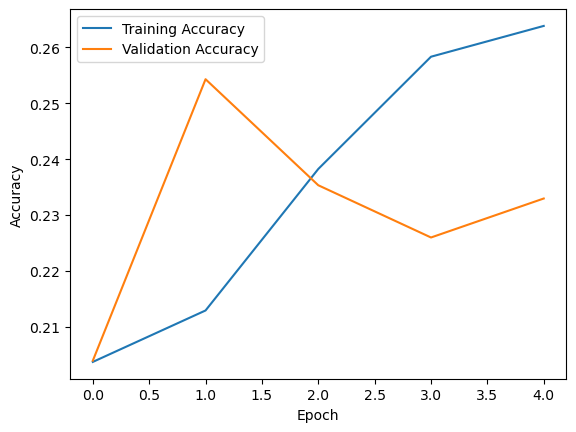

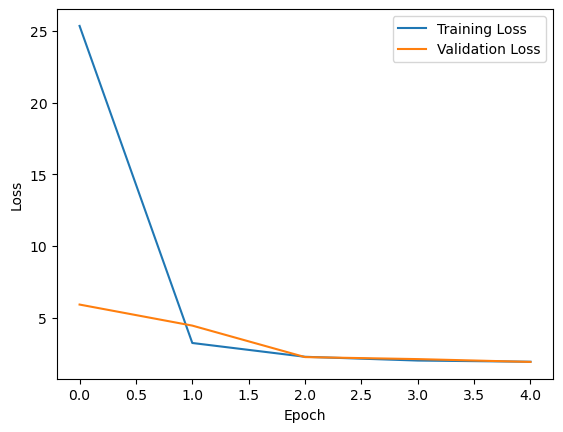

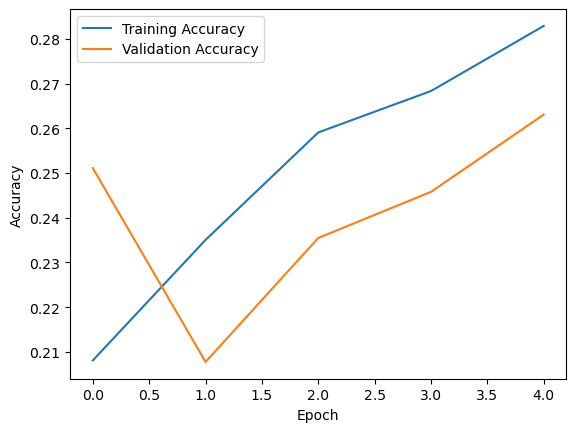

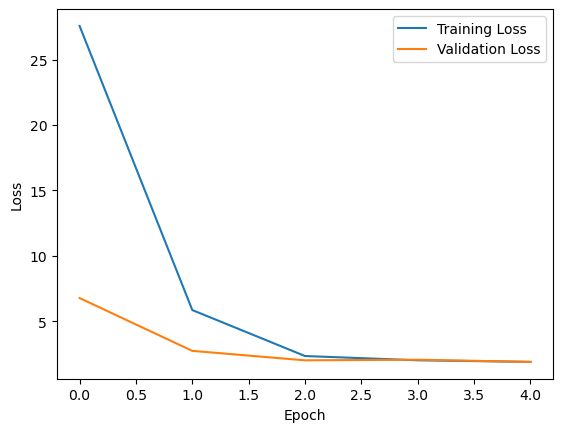

In [72]:
for history in history_list:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# MLP with optimal_components

In [93]:
y_train

array([3, 2, 4, ..., 4, 0, 4])

In [95]:
X_normalized_train.shape

(21532, 2304)

In [97]:
from sklearn.decomposition import PCA 
from time import time 

pca=PCA(n_components=130)
pca.fit(X_normalized_train, X_normalized_test)
X_train_p = pca.transform(X_normalized_train)
X_test_p  =pca.transform(X_normalized_test)

In [99]:
scaler = StandardScaler()
X_normalized_test_p = scaler.fit_transform(X_test_p)
X_normalized_train_p = scaler.fit_transform(X_train_p)


In [101]:
X_normalized_train_p.shape, X_normalized_test_p

((21532, 130),
 array([[-0.30843094,  1.0508144 ,  0.42034112, ..., -0.49178305,
          0.31946925,  0.38398694],
        [-1.67821922, -0.74884033,  0.814414  , ..., -0.64985992,
         -0.50449466,  0.99099283],
        [ 0.77223079, -1.44518479, -0.15446964, ..., -0.03130558,
         -0.72566611,  0.20865453],
        ...,
        [-0.58357193, -0.92671569,  1.38936911, ...,  1.83098901,
          0.68943747,  0.75024782],
        [ 0.47626103, -1.08512448,  0.91289651, ...,  0.68050407,
          0.37562628, -1.01403455],
        [ 0.51744639,  1.61414999, -1.57157979, ...,  1.12636132,
         -0.59245926,  1.42390102]]))

In [120]:
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

pipe_line = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000))
pipe_line.fit(X_normalized_train_p, y_train)
print(classification_report(y_test, pipe_line.predict(X_normalized_test_p)))

              precision    recall  f1-score   support

           0       0.23      0.26      0.24       940
           1       0.27      0.30      0.28       111
           2       0.28      0.28      0.28      1045
           3       0.52      0.50      0.51      1814
           4       0.28      0.28      0.28      1182
           5       0.47      0.51      0.49       836
           6       0.32      0.30      0.31      1250

    accuracy                           0.36      7178
   macro avg       0.34      0.35      0.34      7178
weighted avg       0.37      0.36      0.36      7178



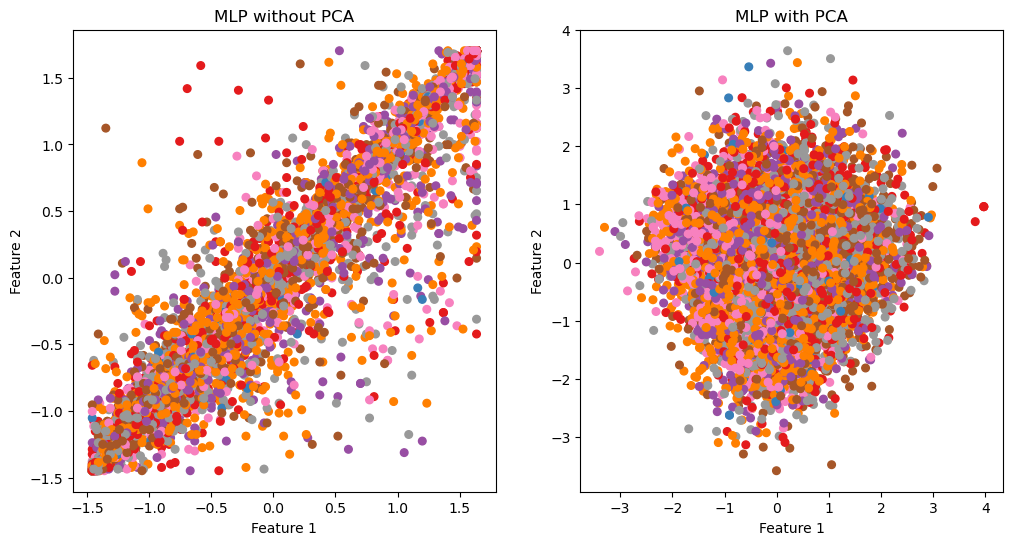

In [128]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_normalized_test[:, 0], X_normalized_test[:, 1], c=y_test, s=30, cmap="Set1")
plt.title("MLP without PCA")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 2, 2)
plt.scatter(X_normalized_test_p[:, 0], X_normalized_test_p[:, 1], c=y_test, s=30, cmap="Set1")
plt.title("MLP with PCA")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.show()

# SVM with Original data

In [103]:
X_normalized_train.shape

(21532, 2304)

In [105]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

scaler = StandardScaler()
X_normalized_train = scaler.fit_transform(X_train_reshaped)
X_normalized_test = scaler.fit_transform(X_test_reshaped)

pipe_line = make_pipeline(StandardScaler(), SVC())
pipe_line.fit(X_normalized_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [119]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pipe_line.predict(X_normalized_test)))

              precision    recall  f1-score   support

           0       0.38      0.21      0.27       940
           1       1.00      0.05      0.10       111
           2       0.41      0.22      0.29      1045
           3       0.50      0.73      0.59      1814
           4       0.32      0.39      0.35      1182
           5       0.66      0.53      0.58       836
           6       0.41      0.42      0.41      1250

    accuracy                           0.44      7178
   macro avg       0.52      0.37      0.37      7178
weighted avg       0.45      0.44      0.43      7178



# SVM apply PCA 

In [110]:
pca = PCA(n_components=130)
pca.fit(X_normalized_train, X_normalized_test)
X_train_pca = pca.transform(X_normalized_train)
X_test_pca  =pca.transform(X_normalized_test)

In [112]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [ 5e3], 
          
              'gamma': [0.0005], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid,n_jobs=-1)
clf = clf.fit(X_train_pca, y_train)

* Apply GridSearch CV with PCA SVM 

In [116]:
from sklearn.metrics import classification_report

y_pred_pca = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           0       0.31      0.39      0.34       940
           1       0.70      0.46      0.55       111
           2       0.36      0.38      0.37      1045
           3       0.57      0.60      0.59      1814
           4       0.35      0.34      0.35      1182
           5       0.65      0.61      0.63       836
           6       0.46      0.39      0.42      1250

    accuracy                           0.46      7178
   macro avg       0.49      0.45      0.46      7178
weighted avg       0.46      0.46      0.46      7178



# Logistic Regression with Original data

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [ ]:
## visualize the confusion matrices and classification reports here